In [1]:
! pip install -r requirements.txt -q

In [2]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# doc = nlp("The system shall encrypt PHI using AES-256.")
# print([token.text for token in doc if token.pos_ == "VERB"])


In [3]:
from google.cloud import bigquery
import os
from langchain_google_vertexai import VertexAI

client = bigquery.Client()
PROJECT_ID = client.project
print(PROJECT_ID)
LOCATION = "us-central1"      

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION
LLM_MODEL="gemini-2.5-pro"

second-sandbox-470608-m2


In [4]:

# ✅ Initialize VertexAI model
try:
    model = VertexAI(
        model_name=llm_model,   # or "gemini-pro", depending on what you enabled
        project=PROJECT_ID,
        location=LOCATION
    )

    # Test a simple prompt
    response = model.invoke("hi")
    print("✅ Response from Vertex AI:", response)

except Exception as e:
    print("❌ Error connecting to Vertex AI:", e)


✅ Response from Vertex AI: Hello! How can I help you today?


# Layer 1- Parse Documents

In [10]:
from app import BatchParser,RequirementBuilder, MetadataEnricher,SemanticValidator

In [8]:




# Step 1: Parse docs
parser = BatchParser(data_folder="data")
parsed_results = parser.parse_batch()

# Step 2: Export to BigQuery
parser.export_results(
    results=parsed_results,
    project_id=PROJECT_ID,
    dataset_id="requirements_dataset",
    table_id="raw_chunks"
)

# Show parsed results
for fname, chunks in parsed_results.items():
    print(f"\n--- {fname} ---")
    for i, chunk in enumerate(chunks[:5]):  # show first 5 chunks
        print(f"{i+1}. {chunk}")


✅ Table second-sandbox-470608-m2.requirements_dataset.raw_chunks already exists.
✅ Inserted 84 rows into second-sandbox-470608-m2.requirements_dataset.raw_chunks
💾 Saved 84 requirements locally → requirements.json

--- data/Common_InsuranceReqs_FINAL.pdf ---
1. {'id': 'a2c871ab-fdcc-48de-99a5-730caab69e0f', 'requirement_id': 'REQ-001', 'filename': 'Common_InsuranceReqs_FINAL.pdf', 'statement': 'These requirements have since been used by a variety of stakeholders, including the Open Health Information Exchange (OpenHIE), the open source Health Insurance Management Information System (openIMIS), and several country governments, including that of Bangladesh.', 'created_at': '2025-08-31T17:06:47.648111'}
2. {'id': '049336f3-03a9-4783-894a-636380aa4191', 'requirement_id': 'REQ-002', 'filename': 'Common_InsuranceReqs_FINAL.pdf', 'statement': 'These requirements have since been used by a variety of stakeholders, including the Open Health Information Exchange (OpenHIE), the open source Health 

## Requirement Registry Layer (Functional Step 2)

Purpose: Convert raw requirement candidates into structured requirements. and remove duplciate requirements

In [9]:
%time 

import json
import asyncio

builder = RequirementBuilder(model=llm_model, project_id=PROJECT_ID)

# ------------------ Load Input from Layer 1 ------------------
# Layer 1 (BatchParser) saved clean requirements into requirements.json
with open("requirements.json", "r", encoding="utf-8") as f:
    requirements = json.load(f)  
    
raw_reqs = requirements

# ------------------ Build Structured Requirements (Layer 2) ------------------
async def async_build_registry():
    return await builder.build_registry(raw_reqs, batch_size=100)

structured_reqs = await async_build_registry()

# Save Layer 2 output
with open("structured_requirements.json", "w", encoding="utf-8") as f:
    json.dump(structured_reqs, f, indent=2)

print(f"💾 Saved {len(structured_reqs)} structured requirements → structured_requirements.json")

try:
    builder.export_to_bq(
    structured_reqs,
    dataset_id="requirements_dataset",
    table_id="requirements",
    batch_size=100   
)
except Exception as e:
    print(f"⚠️ BigQuery export failed: {e} (saved locally instead)")


CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.44 μs


Processing requirements: 100%|██████████| 1/1 [00:24<00:00, 24.42s/it]

Skipping duplicate requirement: REQ-002
Skipping duplicate requirement: REQ-014
Skipping duplicate requirement: REQ-028
Skipping duplicate requirement: REQ-036
Skipping duplicate requirement: REQ-047
Skipping duplicate requirement: REQ-049
Skipping duplicate requirement: REQ-072
Skipping duplicate requirement: REQ-079
Skipping duplicate requirement: REQ-084
💾 Saved 75 structured requirements → structured_requirements.json


Table second-sandbox-470608-m2.requirements_dataset.requirements exists.
Inserted batch 1 (75 rows).
Finished inserting 75 rows into second-sandbox-470608-m2.requirements_dataset.requirements


# Layer 3 – Metadata Enrichment

Add domain-specific, fine-grained attributes to requirements produced in Layer 2 using rules + NLP, making them richer and standardized for compliance, analytics, and test case mapping.

In [12]:
import json
from google.cloud import bigquery


def load_requirements_from_bigquery(project_id: str,
                                    dataset_id: str = "requirements_dataset",
                                    table_id: str = "requirements") -> list[dict]:
    """
    Load requirements from BigQuery and return as a list of dicts.

    Args:
        project_id (str): GCP project ID
        dataset_id (str): BigQuery dataset name
        table_id (str): BigQuery table name

    Returns:
        list[dict]: Parsed requirements with metadata as dict
    """
    client = bigquery.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    query = f"""
    SELECT
      requirement_id,
      category,
      title,
      statement,
      priority,
      severity,
      regulation,
      actors,
      data_type,
      action,
      acceptance_criteria,
      dependencies,
      traceability,
      metadata,
      created_at
    FROM `{table_ref}`
    """
    query_job = client.query(query)
    rows = query_job.result()

    structured_reqs = [dict(row) for row in rows]

    # Parse metadata JSON if stored as string
    for req in structured_reqs:
        if isinstance(req.get("metadata"), str):
            try:
                req["metadata"] = json.loads(req["metadata"])
            except Exception:
                req["metadata"] = {}

    print(f"Loaded {len(structured_reqs)} requirements from BigQuery.")
    return structured_reqs


def enrich_requirements(requirements: list[dict],
                        output_file: str = "enriched_requirements.json") -> list[dict]:
    """
    Enrich requirements metadata and save to JSON.

    Args:
        requirements (list[dict]): Raw requirements
        output_file (str): File to save enriched requirements

    Returns:
        list[dict]: Enriched requirements
    """
    enricher = MetadataEnricher()
    enriched_reqs = enricher.enrich(requirements)

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(enriched_reqs, f, indent=2)

    print(f"Enriched {len(enriched_reqs)} requirements → {output_file}")
    return enriched_reqs


# Step 1: Load
requirements = load_requirements_from_bigquery(
    project_id=PROJECT_ID,
    dataset_id="requirements_dataset",
    table_id="requirements"
)

# Step 2: Enrich
enriched_reqs = enrich_requirements(requirements, "enriched_requirements.json")


Loaded 385 requirements from BigQuery.


Enriching requirements: 100%|██████████| 385/385 [00:04<00:00, 91.11it/s] 

Enriched 385 requirements → enriched_requirements.json


In [13]:
enriched_reqs[0]

{'requirement_id': 'REQ-004',
 'category': 'Compliance',
 'title': 'Update National Health Insurance Information Systems Guide',
 'statement': 'A Guide to Common Requirements for National Health Insurance Information Systems This document, , is the result of that Determining workshop and the next step toward updating the content of the 2012 document.',
 'priority': 'P1',
 'severity': 'Major',
 'regulation': ['HIPAA'],
 'actors': ['Administrator', 'Compliance Officer'],
 'data_type': ['PHI'],
 'action': [],
 'acceptance_criteria': ["A new version of the 'Guide to Common Requirements for National Health Insurance Information Systems' is created and published.",
  "The new guide incorporates the results of the 'Determining workshop'.",
  'The new guide serves as an official update to the 2012 version of the document.'],
 'dependencies': [],
 'traceability': [],
 'metadata': {'enrichment': {'domain': 'healthcare',
   'regulation_sections': [],
   'normalized': {'actors': ['Administrator', 

# Layer 4 – Categorization & Retrieval Layer (Functional Step 4)

Purpose: Classify requirements and enable semantic retrieval.

In [28]:
import json
import asyncio
from app import CategorizerRetriever
async def categorize_and_store_requirements(project_id: str,
                                            llm_model: str,
                                            enriched_file: str = "enriched_requirements.json",
                                            embedding_model: str = "text-embedding-005",
                                            dataset_id: str = "requirements_dataset",
                                            table_id: str = "requirements") -> list[dict]:
    """
    Categorize + embed enriched requirements and export to BigQuery.

    Args:
        project_id (str): GCP project ID
        llm_model (str): LLM model name for classification
        enriched_file (str): Path to enriched requirements JSON
        embedding_model (str): Embedding model to use
        dataset_id (str): BigQuery dataset name
        table_id (str): BigQuery table name

    Returns:
        list[dict]: Categorized requirements
    """

    # Load enriched requirements
    with open(enriched_file, "r", encoding="utf-8") as f:
        enriched_reqs = json.load(f)
    
    # enriched_reqs=enriched_reqs[:5]
    # Initialize CategorizerRetriever
    cr = CategorizerRetriever(
        project_id=project_id,
        embedding_model=embedding_model,
        classifier_model=llm_model
    )

    # Step 1: Categorize + embed
    categorized_reqs = await cr.process_async(enriched_reqs, batch_size=100)

    # Step 2: Save to BigQuery
    cr.export_to_bq(categorized_reqs, dataset_id=dataset_id, table_id=table_id)

    print(f"Processed {len(categorized_reqs)} requirements → exported to {dataset_id}.{table_id}")
    return categorized_reqs


# Run async function
categorized_reqs = await categorize_and_store_requirements(
        project_id=PROJECT_ID,
        llm_model=LLM_MODEL,
        enriched_file="enriched_requirements.json",
        embedding_model="text-embedding-005",
        dataset_id="requirements_dataset",
        table_id="requirements_categorized"
    )



/opt/conda/lib/python3.10/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
Classifying:  25%|██▌       | 1/4 [00:41<02:03, 41.18s/it]/opt/conda/lib/python3.10/asyncio/tasks.py:665: RuntimeWarning: coroutine 'categorize_and_store_requirements' was never awaited
  super().__init__(loop=loop)
Classifying: 100%|██████████| 4/4 [02:44<00:00, 41.03s/it]


Table second-sandbox-470608-m2.requirements_dataset.requirements_categorized exists.
Inserted 385 categorized requirements into second-sandbox-470608-m2.requirements_dataset.requirements_categorized
Processed 385 requirements → exported to requirements_dataset.requirements_categorized


In [29]:
import pandas as pd

# categorized_reqs is a list of dicts
df = pd.DataFrame(categorized_reqs)

df.head()

,requirement_id,category,title,statement,priority,severity,regulation,actors,data_type,action,acceptance_criteria,dependencies,traceability,metadata,created_at,embedding
0,REQ-004,Compliance,Update National Health Insurance Information S...,A Guide to Common Requirements for National He...,P1,Major,[HIPAA],"[Administrator, Compliance Officer]",[PHI],[],[A new version of the 'Guide to Common Require...,[],[],"{'enrichment': {'domain': 'healthcare', 'regul...",2025-08-31T03:52:39.847007,"[-0.013139056041836739, 0.030909523367881775, ..."
1,REQ-004,Compliance,Update National Health Insurance System Requir...,A Guide to Common Requirements for National He...,P1,Major,[HIPAA],"[Administrator, Compliance Officer]",[PHI],[modify],[The content of the 2012 guide document is rev...,[],[],"{'llm_model': 'gemini-2.5-pro', 'raw_input': '...",2025-08-31T12:31:36.507912,"[-0.013139056041836739, 0.030909523367881775, ..."
2,REQ-004,Compliance,Update National Health Insurance Information S...,A Guide to Common Requirements for National He...,P1,Major,[HIPAA],"[Administrator, Compliance Officer]",[PHI],[],[A new version of the 'Guide to Common Require...,[],[],"{'enrichment': {'domain': 'healthcare', 'regul...",2025-08-31T03:52:39.847007,"[-0.013139056041836739, 0.030909523367881775, ..."
3,REQ-004,Compliance,Update National Health Insurance System Requir...,A Guide to Common Requirements for National He...,P1,Major,[HIPAA],"[Administrator, Compliance Officer]",[PHI],[modify],[The content of the 2012 guide document is rev...,[],[],"{'enrichment': {'domain': 'healthcare', 'regul...",2025-08-31T12:31:36.507912,"[-0.013139056041836739, 0.030909523367881775, ..."
4,REQ-067,Compliance,Common Requirements Document Baseline,A common requirements document shall be establ...,P1,Major,"[FDA 21 CFR 820.30 Design Controls, ISO 13485:...","[Software Developer, QA Engineer, System Archi...",[Requirements Documentation],"[use, customize, maintain, create]",[A version-controlled common requirements docu...,[],[],"{'llm_model': 'gemini-2.5-pro', 'raw_input': '...",2025-08-31T17:08:09.371536,"[-0.007004974409937859, -0.011259847320616245,..."


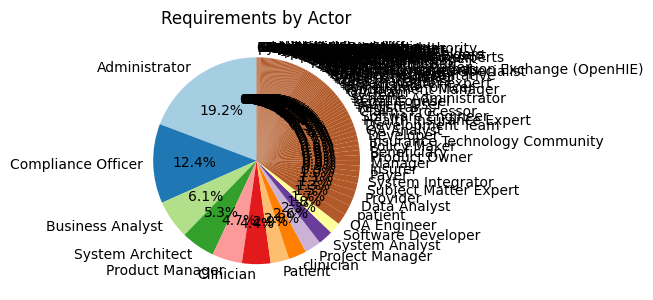

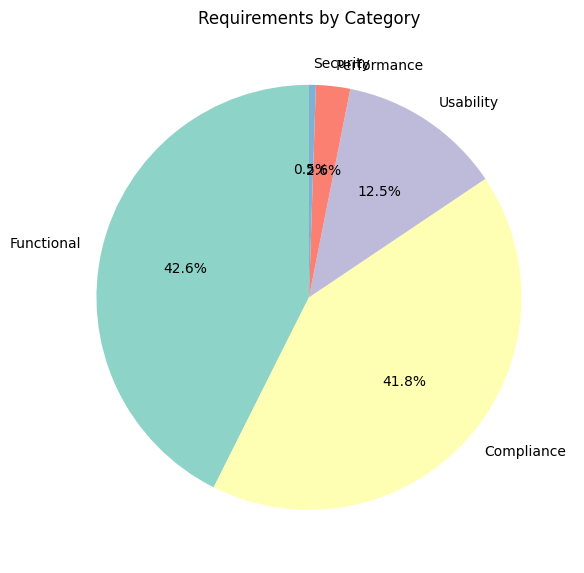

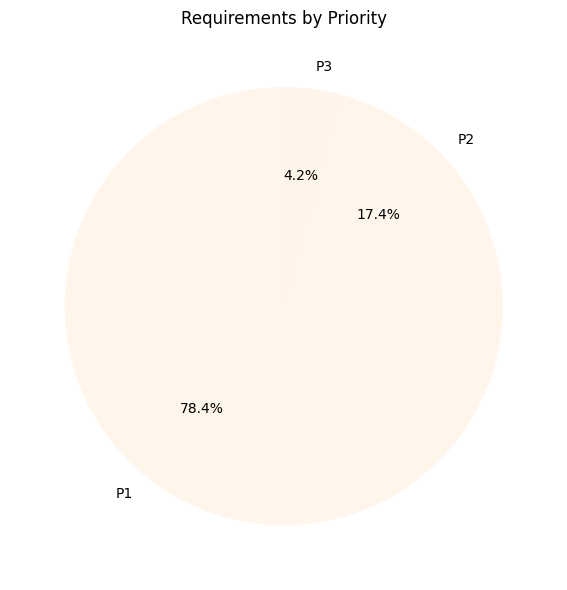

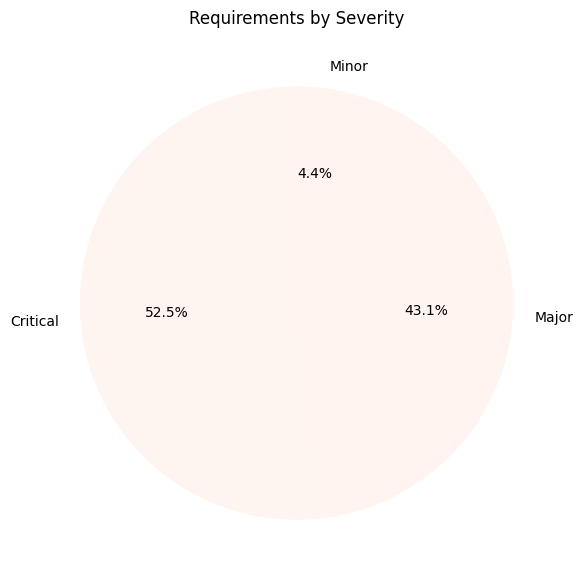

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_requirements_by_actor_pie(df: pd.DataFrame):
    """Pie chart: total requirements per actor."""
    actor_expanded = df.explode("actors")
    actor_counts = actor_expanded["actors"].value_counts()

    plt.figure(figsize=(6, 6))
    actor_counts.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Paired(range(len(actor_counts)))
    )
    plt.title("Requirements by Actor")
    plt.ylabel("")  # hide y-label
    plt.tight_layout()
    plt.show()


def plot_requirements_by_category_pie(df: pd.DataFrame):
    """Pie chart: distribution of categories overall."""
    category_counts = df["category"].value_counts()

    plt.figure(figsize=(6, 6))
    category_counts.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Set3(range(len(category_counts)))
    )
    plt.title("Requirements by Category")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


def plot_requirements_by_priority_pie(df: pd.DataFrame):
    """Pie chart: distribution of priorities overall."""
    priority_counts = df["priority"].value_counts()

    plt.figure(figsize=(6, 6))
    priority_counts.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Oranges(range(len(priority_counts)))
    )
    plt.title("Requirements by Priority")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


def plot_requirements_by_severity_pie(df: pd.DataFrame):
    """Pie chart: distribution of severity overall."""
    severity_counts = df["severity"].value_counts()

    plt.figure(figsize=(6, 6))
    severity_counts.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Reds(range(len(severity_counts)))
    )
    plt.title("Requirements by Severity")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()



# ================== CALL FUNCTIONS ==================
plot_requirements_by_actor_pie(df)
plot_requirements_by_category_pie(df)
plot_requirements_by_priority_pie(df)
plot_requirements_by_severity_pie(df)


# Layer 5 – Test Case Generation Layer 

This layer will:

-- Take requirements from Layer 4 (categorized_reqs).
- Generate 3 test cases per requirement (Positive, Negative, Edge).
- Normalize into a consistent schema.
- Export into BigQuery (test_cases table), just like we did for requirements.

In [35]:
import json
from google.cloud import bigquery
from app import TestCaseGenerator


async def generate_and_store_test_cases(
    project_id: str,
    dataset_id: str = "requirements_dataset",
    requirements_table: str = "requirements_categorized",
    testcases_table: str = "test_cases",
    save_local: bool = True,
    local_file: str = "test_cases.json",
    limit: int = None,
    batch_size: int = 100,
    export_batch_size: int = 200,
) -> list[dict]:
    """
    Generate test cases from requirements and export to BigQuery.

    Args:
        project_id (str): GCP project ID
        dataset_id (str): BigQuery dataset ID
        requirements_table (str): Table containing categorized requirements
        testcases_table (str): Table to store generated test cases
        save_local (bool): Save test cases to a local JSON file
        local_file (str): Path to local file for saving test cases
        limit (int): Limit number of requirements (useful for testing)
        batch_size (int): Batch size for test case generation
        export_batch_size (int): Batch size for BigQuery export

    Returns:
        list[dict]: Generated test cases
    """
    # Step 1: Load requirements from BigQuery
    client = bigquery.Client(project=project_id)
    query = f"""
        SELECT requirement_id, category, title, statement, priority, severity
        FROM `{project_id}.{dataset_id}.{requirements_table}`
    """
    rows = client.query(query).result()
    requirements = [dict(row) for row in rows]

    if limit:
        requirements = requirements[:limit]

    print(f"Loaded {len(requirements)} requirements from BigQuery")

    # Step 2: Generate test cases
    tcg = TestCaseGenerator(project_id)
    test_cases = await tcg.batch_generate_async(requirements, batch_size=batch_size)

    # Step 3: Export test cases back into BigQuery
    tcg.export_to_bq(
        test_cases,
        dataset_id=dataset_id,
        table_id=testcases_table,
        batch_size=export_batch_size,
    )

    # Step 4: Save locally if enabled
    if save_local:
        with open(local_file, "w", encoding="utf-8") as f:
            json.dump(test_cases, f, indent=2)
        print(f"Saved test cases locally → {local_file}")

    print(f"Exported {len(test_cases)} test cases to BigQuery → {dataset_id}.{testcases_table}")
    return test_cases

# Run async function
test_cases =await  generate_and_store_test_cases(
        project_id=PROJECT_ID,
        dataset_id="requirements_dataset",
        requirements_table="requirements_categorized",
        testcases_table="test_cases",
        save_local=True,
        limit=10   # take only first 5 for testing
    )



Loaded 10 requirements from BigQuery


Generating Test Cases: 100%|██████████| 1/1 [00:35<00:00, 35.50s/it]


Table second-sandbox-470608-m2.requirements_dataset.test_cases exists.
Inserted batch 1 (30 rows).
Finished inserting 30 test cases into second-sandbox-470608-m2.requirements_dataset.test_cases
Saved test cases locally → test_cases.json
Exported 30 test cases to BigQuery → requirements_dataset.test_cases


In [38]:
df=pd.DataFrame(test_cases)
df

,test_id,requirement_id,title,description,preconditions,steps,test_data,expected_result,postconditions,priority,severity,type,execution_status,owner,created_at
0,TC_NHIS_DOC_001,REQ-004,Positive: Verify successful search and retriev...,This test case verifies that a user with the c...,[User is authenticated and logged into the Hea...,[Navigate to the document repository or search...,{'search_query': 'A Guide to Common Requiremen...,[The search returns the correct document as th...,"[User session remains active., No data is alte...",P1,Major,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850316
1,TC_NHIS_DOC_002,REQ-004,Negative: Verify system behavior when searchin...,This test case ensures that the system provide...,[User is authenticated and logged into the Hea...,[Enter a random or nonsensical string into the...,{'search_query': 'Non-Existent Document XYZ123'},[The system displays a 'No results found' or '...,"[User session remains active., The search log ...",P2,Minor,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850336
2,TC_NHIS_DOC_003,REQ-004,Edge: Verify retrieval of the outdated 2012 do...,This edge case tests the system's version cont...,[User is authenticated and logged into the Hea...,[Navigate to the document repository or search...,{'search_query': '2012 National Health Insuran...,"[The 2012 document is successfully displayed.,...",[User is made aware of the most current docume...,P2,Major,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850346
3,TC_DOC_UPDATE_001,REQ-004,Positive: Verify successful update of an exist...,This test case verifies that a user with appro...,[User is logged into the National Health Insur...,"[Navigate to the Document Repository section.,...","{'user_role': 'Document Manager', 'document_to...",[A success message 'Document updated successfu...,"[The new document is the active version., An a...",P1,Critical,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850406
4,TC_DOC_UPDATE_002,REQ-004,Negative: Verify system rejects document updat...,This test case ensures the system prevents a u...,[User is logged into the National Health Insur...,"[Navigate to the Document Repository section.,...","{'user_role': 'Document Manager', 'document_to...","[An error message is displayed, such as 'Inval...",[No changes are made to the document or its ve...,P1,Major,Security,Not Executed,QA Team,2025-08-31T17:44:17.850415
5,TC_DOC_UPDATE_003,REQ-004,Edge: Verify document update with a file at th...,This test case checks the system's boundary co...,[User is logged into the National Health Insur...,"[Navigate to the Document Repository section.,...","{'user_role': 'Document Manager', 'document_to...",[The file upload completes successfully withou...,"[The new, large document is accessible and dow...",P2,Major,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850424
6,TC-POS-001,REQ-004,Verify successful access to the updated 'Guide...,This test case ensures that a user with the co...,[User is authenticated and logged into the Hea...,[Navigate to the 'Document Repository' or 'Sea...,{'search_query': 'A Guide to Common Requiremen...,"[The search returns a single, accurate result ...","[The user's session remains active., An audit ...",P1,Critical,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850470
7,TC-NEG-001,REQ-004,Verify system behavior when attempting to acce...,This test case ensures that the system prevent...,[User is authenticated and logged into the Hea...,[Navigate to the 'Document Repository' or 'Sea...,{'search_query': 'A Guide to Common Requiremen...,[The system does not return a direct link to t...,[The user is not able to view or download the ...,P2,Major,Functional,Not Executed,QA Team,2025-08-31T17:44:17.850478
8,TC-EDG-001,REQ-004,Verify document search using a partial title s...,This test case validates the search functional...,[User is authenticated and logged into the Hea...,[Navigate to the 'Document Repository' or 'Sea...,{'search_query': 'National Health Insura

# Layer 6 – Coverage Validation Layer

### Create a BigQuery view for reporting — joining requirements ↔ test_cases into a traceability matrix.

- Check coverage: every requirement must have ≥ 1 Positive, 1 Negative, 1 Edge test case.
- Build a traceability matrix mapping:
- requirements → use_cases → test_cases.
- Validate requirement IDs & test case IDs with regex.




In [4]:
from google.cloud import bigquery

dataset_id = "requirements_dataset"
requirements_table = "requirements_categorized"
testcases_table = "test_cases"
view_name = "requirements_testcases_view"

client = bigquery.Client(project=PROJECT_ID)

# SQL for the join view
sql = f"""
CREATE OR REPLACE VIEW `{PROJECT_ID}.{dataset_id}.{view_name}` AS
SELECT 
  r.requirement_id,
  r.title AS requirement_title,
  r.statement AS requirement_statement,
  r.priority AS requirement_priority,
  r.severity AS requirement_severity,
  t.test_id,
  t.title AS test_title,
  t.description AS test_description,
  t.priority AS test_priority,
  t.severity AS test_severity,
  t.execution_status,
  t.owner,
  t.created_at
FROM `{PROJECT_ID}.{dataset_id}.{requirements_table}` r
LEFT JOIN `{PROJECT_ID}.{dataset_id}.{testcases_table}` t
ON r.requirement_id = t.requirement_id
ORDER BY r.requirement_id, t.test_id;
"""

# Create or replace the view
job = client.query(sql)
job.result()

print(f"✅ Created or updated view: {PROJECT_ID}.{dataset_id}.{view_name}")

query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{dataset_id}.requirements_testcases_view`
    LIMIT 20
"""
results = client.query(query).result()

# Convert to DataFrame
df = results.to_dataframe()



✅ Created or updated view: second-sandbox-470608-m2.requirements_dataset.requirements_testcases_view


In [40]:
df.head(10)

,requirement_id,requirement_title,requirement_statement,requirement_priority,requirement_severity,test_id,test_title,test_description,test_priority,test_severity,execution_status,owner,created_at
0,REQ-001,Stakeholder Adoption and Usage,These requirements have since been used by a v...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:46:24.770465+00:00
1,REQ-001,Stakeholder and Standards Alignment,The system must align with requirements used b...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
2,REQ-001,Stakeholder Adoption and Usage,These requirements have since been used by a v...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
3,REQ-001,Stakeholder and Standards Alignment,The system must align with requirements used b...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
4,REQ-001,Stakeholder and Standards Alignment,The system must align with requirements used b...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify correct display of specified ...,This test case verifies that the system correc...,P1,Major,Not Executed,QA Team,2025-08-31 12:44:56.214952+00:00
5,REQ-001,Stakeholder Adoption,These requirements have since been used by a v...,P3,Minor,TC-STAKEHOLDER-001,Positive: Verify correct display of specified ...,This test case verifies that the system correc...,P1,Major,Not Executed,QA Team,2025-08-31 12:44:56.214952+00:00
6,REQ-001,Stakeholder Adoption,These requirements have since been used by a v...,P3,Minor,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
7,REQ-001,Stakeholder Adoption and Usage,These requirements have since been used by a v...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
8,REQ-001,Stakeholder Adoption,These requirements have since been used by a v...,P3,Minor,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:44:56.208955+00:00
9,REQ-001,Stakeholder and Standards Alignment,The system must align with requirements used b...,P1,Major,TC-STAKEHOLDER-001,Positive: Verify a known stakeholder is displayed,This test case verifies that a stakeholder exp...,P1,Critical,Not Executed,QA Team,2025-08-31 12:46:24.770465+00:00


In [65]:
# TODO: add requirement_severity in test covergae to plot graph

In [5]:
from app import CoverageValidator
from google.cloud import bigquery
import pandas as pd


def build_traceability_matrix(
    project_id: str,
    dataset_id: str = "requirements_dataset",
    requirements_table: str = "requirements_categorized",
    testcases_table: str = "test_cases",
    table_name: str = "traceability_matrix",
    drop_old: bool = True
) -> pd.DataFrame:
    """
    Build or refresh the requirements traceability matrix.

    Args:
        project_id (str): GCP project ID
        dataset_id (str): BigQuery dataset name
        table_name (str): Table to store traceability matrix
        drop_old (bool): Whether to drop the old table before rebuilding

    Returns:
        pd.DataFrame: Traceability matrix results
    """
    client = bigquery.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_name}"

    # Step 1: Drop old table if requested
    if drop_old:
        client.delete_table(table_ref, not_found_ok=True)
        print(f"🗑️ Dropped old table {table_ref}")

    # Step 2: Run CoverageValidator (this also re-creates the table and inserts rows)
    cv = CoverageValidator(project_id=project_id, dataset_id=dataset_id)
    trace_matrix = cv.build_traceability_matrix( requirements_table, testcases_table)

    # Step 3: Convert to DataFrame for easy inspection
    df = pd.DataFrame(trace_matrix)
    if not df.empty:
        print(df[["requirement_id", "coverage_status", "coverage_percent", "coverage_gaps"]].head())
    else:
        print("⚠️ No data returned from CoverageValidator")

    return df

df_trace = build_traceability_matrix(
    project_id=PROJECT_ID,
    dataset_id="requirements_dataset",
    drop_old=True
)


🗑️ Dropped old table second-sandbox-470608-m2.requirements_dataset.traceability_matrix
  requirement_id coverage_status  coverage_percent coverage_gaps
0        REQ-004            FULL               100            []
1        REQ-067            FULL               100            []
2        REQ-074            FULL               100            []
3        REQ-020            FULL               100            []
4        REQ-059            FULL               100            []


In [6]:
df_trace

,requirement_id,use_case_id,test_case_ids,coverage_status,coverage_percent,coverage_gaps,compliance,created_at,valid_ids
0,REQ-004,None,"[TC_NHIS_GUIDE_001, TC_NHIS_GUIDE_002, TC_NHIS...",FULL,100,[],"[HIPAA, National Health Insurance Regulations]",2025-08-31T17:56:47.908768,False
1,REQ-067,None,"[TC_REQ_DOC_001, TC_REQ_DOC_002, TC_REQ_DOC_003]",FULL,100,[],"[FDA 21 CFR 820.30 Design Controls, ISO 13485:...",2025-08-31T17:56:47.908794,False
2,REQ-074,None,"[TC_BPA_001_POS, TC_BPA_002_NEG, TC_BPA_003_ED...",FULL,100,[],"[FDA 21 CFR Part 820, ISO 27001, HIPAA Securit...",2025-08-31T17:56:47.908812,False
3,REQ-020,None,"[TC_POS_001, TC_NEG_002, TC_EDG_003, TC_HP_001...",FULL,100,[],"[HIPAA, ISO, FDA, GDPR, FDA 21 CFR Part 820, I...",2025-08-31T17:56:47.908831,False
4,REQ-059,None,"[TC_EVAL_001, TC_EVAL_002, TC_EVAL_003, TC_PRO...",FULL,100,[],"[GDPR, HIPAA Security Rule - § 164.308(a)(8) E...",2025-08-31T17:56:47.908845,False
...,...,...,...,...,...,...,...,...,...
74,REQ-031,None,"[TC_TS_001, TC_TS_002, TC_TS_003, TS_SET_001_P...",FULL,100,[],"[ISO - 13485:2016, HIPAA - 45 CFR 164.308(a)(1...",2025-08-31T17:56:47.909769,False
75,REQ-032,None,"[TC_TS_001, TC_TS_002, TC_TS_003, TS_TC_001, T...",FULL,100,[],[HIPAA 164.308(a)(1)(ii)(A) - Implementation o...,2025-08-31T17:56:47.909780,False
76,REQ-030,None,"[TC_FHIR_001, TC_FHIR_002, TC_FHIR_003, TC_FHI...",FULL,100,[],"[ISO 13606, FHIR, HIPAA (Security Rule - § 164...",2025-08-31T17:56:47.909793,False
77,REQ-066,None,"[TC_CUSTOM_001, TC_CUSTOM_002, TC_CUSTOM_003, ...",FULL,100,[],"[FDA 21 CFR Part 820 - 820.30 Design Controls,...",2025-08-31T17:56:47.909808,False


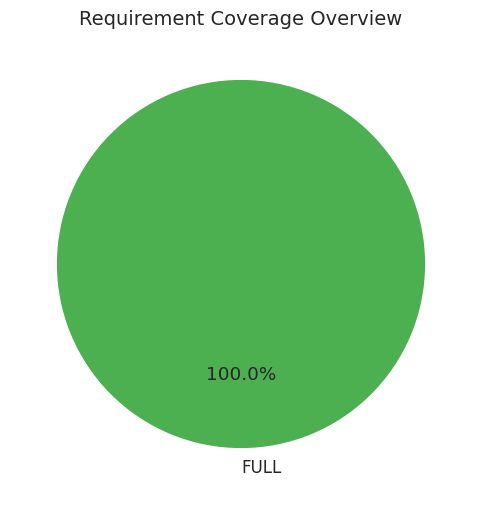

✅ All requirements have full test coverage (no gaps).


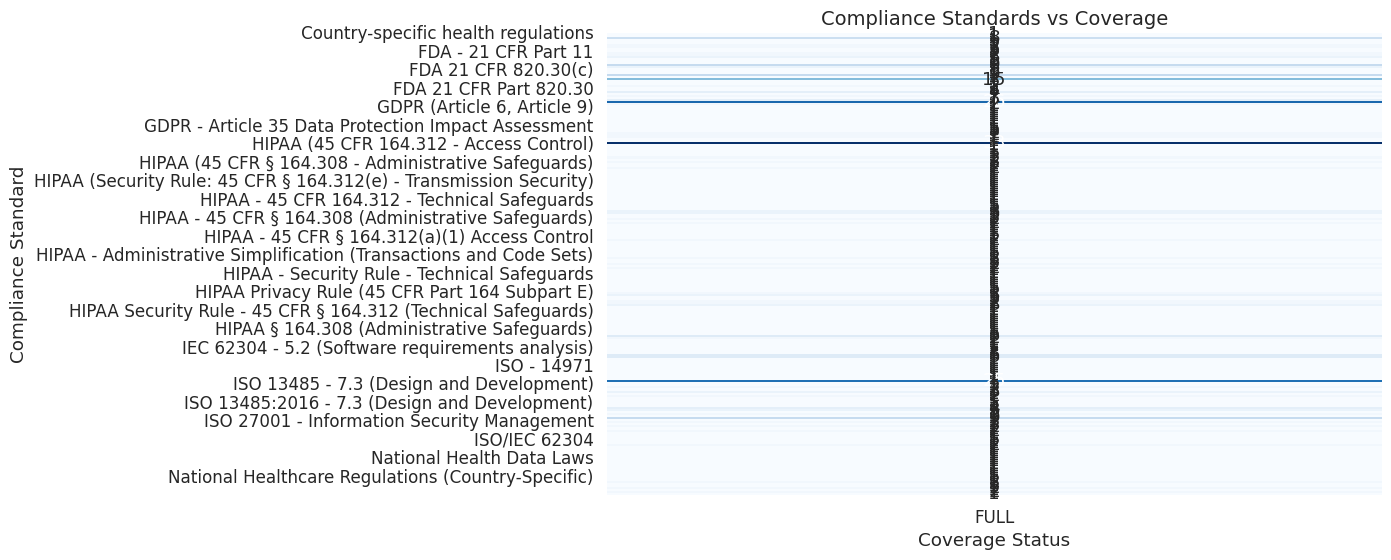

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_business_graphs(df):
    # Set style
    sns.set(style="whitegrid", font_scale=1.1)

    # 1. High-level coverage status (Pie chart)
    plt.figure(figsize=(6,6))
    df["coverage_status"].value_counts().plot(
        kind="pie", autopct='%1.1f%%', startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"]
    )
    plt.title("Requirement Coverage Overview", fontsize=14)
    plt.ylabel("")
    plt.show()

    # 2. Coverage gaps summary (stacked bar)
    gap_counts = pd.Series([gap for gaps in df["coverage_gaps"] for gap in gaps if gaps])
    if not gap_counts.empty:
        plt.figure(figsize=(7,5))
        gap_counts.value_counts().plot(kind="barh", color="salmon")
        plt.title("Test Coverage Gaps (Missing Types)", fontsize=14)
        plt.xlabel("Number of Missing Cases")
        plt.ylabel("Gap Type")
        plt.show()
    else:
        print("✅ All requirements have full test coverage (no gaps).")

    # 3. Compliance vs coverage (heatmap for risk visibility)
    compliance_expanded = df.explode("compliance")
    heatmap_data = pd.crosstab(compliance_expanded["compliance"], compliance_expanded["coverage_status"])

    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Compliance Standards vs Coverage", fontsize=14)
    plt.ylabel("Compliance Standard")
    plt.xlabel("Coverage Status")
    plt.show()



plot_business_graphs(df_trace)


# (Optional) LLM-based semantic validation that the test case really matches the requirement.

In [10]:
import pandas as pd
from google.cloud import bigquery
from app import SemanticValidator


async def run_semantic_validation(
    project_id: str,
    dataset_id: str = "requirements_dataset",
    requirements_table: str = "requirements",
    testcases_table: str = "test_cases",
    output_table: str = "semantic_validation",
    limit: int = None,
    batch_size: int = 2,
) -> pd.DataFrame:
    """
    Run semantic validation between requirements and test cases, then export results to BigQuery.

    Args:
        project_id (str): GCP project ID
        dataset_id (str): BigQuery dataset ID
        requirements_table (str): Table containing requirements
        testcases_table (str): Table containing test cases
        output_table (str): Table to store semantic validation results
        limit (int): Limit number of rows for testing
        batch_size (int): Batch size for async validation

    Returns:
        pd.DataFrame: Semantic validation results
    """
    client = bigquery.Client(project=project_id)

    # Step 1: Load requirements
    req_query = f"""
        SELECT DISTINCT requirement_id, statement
        FROM `{project_id}.{dataset_id}.{requirements_table}`
    """
    requirements = [dict(row) for row in client.query(req_query).result()]

    # Step 2: Load test cases
    tc_query = f"""
        SELECT DISTINCT test_id, requirement_id, title, description, steps, expected_result
        FROM `{project_id}.{dataset_id}.{testcases_table}`
    """
    test_cases = [dict(row) for row in client.query(tc_query).result()]

    # Optionally limit for testing
    if limit:
        requirements = requirements[:limit]
        test_cases = test_cases[:limit]

    print(f"📥 Loaded {len(requirements)} requirements and {len(test_cases)} test cases")

    # Step 3: Run semantic validation
    sv = SemanticValidator(project_id=project_id)
    validated = await sv.validate_async(requirements, test_cases, batch_size=batch_size)

    # Step 4: Export to BigQuery
    sv.export_to_bq(validated, table_id=output_table)

    # Step 5: Return as DataFrame
    df = pd.DataFrame(validated)
    print(f"Exported {len(df)} validation results to {dataset_id}.{output_table}")

    return df

df_validated = await run_semantic_validation(
        project_id=PROJECT_ID,
        dataset_id="requirements_dataset",
        requirements_table="requirements_categorized",
        testcases_table="test_cases",
        output_table="semantic_validation",
        limit=5,   # just take 5 for testing
        batch_size=2
    )


print(df_validated.head())



📥 Loaded 5 requirements and 5 test cases


Semantic validating test cases: 100%|██████████| 2/2 [00:21<00:00, 10.55s/it]


✅ Inserted batch 1 (3 rows).
Finished inserting 3 rows into second-sandbox-470608-m2.requirements_dataset.semantic_validation
Exported 3 validation results to requirements_dataset.semantic_validation
                          validation_id         test_id requirement_id  \
0  6c9bf3b6-f970-40c3-a204-42b4637a183e  TC_REQ_DOC_001        REQ-067   
1  5e5c7aca-4a0f-459e-8ff0-cae3a84d9e60  TC_REQ_DOC_002        REQ-067   
2  52668377-7cb7-4a65-afdd-db295341f13a  TC_REQ_DOC_003        REQ-067   

   semantic_matches  semantic_confidence  \
0              True                  100   
1              True                  100   
2              True                   95   

                                     semantic_reason  \
0  The test case directly validates the core aspe...   
1  The requirement states the document must be ad...   
2  The requirement mandates that the document is ...   

                   created_at  
0  2025-08-31T17:59:57.176959  
1  2025-08-31T17:59:57.177009  
2  20

In [11]:
df_validated

,validation_id,test_id,requirement_id,semantic_matches,semantic_confidence,semantic_reason,created_at
0,6c9bf3b6-f970-40c3-a204-42b4637a183e,TC_REQ_DOC_001,REQ-067,True,100,The test case directly validates the core aspe...,2025-08-31T17:59:57.176959
1,5e5c7aca-4a0f-459e-8ff0-cae3a84d9e60,TC_REQ_DOC_002,REQ-067,True,100,The requirement states the document must be ad...,2025-08-31T17:59:57.177009
2,52668377-7cb7-4a65-afdd-db295341f13a,TC_REQ_DOC_003,REQ-067,True,95,The requirement mandates that the document is ...,2025-08-31T18:00:04.660901


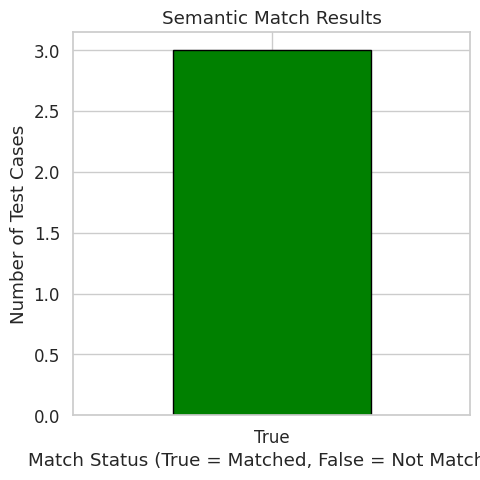

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df=df_validated
# ================== VISUALIZATION ==================
# Count matches vs non-matches
match_counts = df["semantic_matches"].value_counts()

plt.figure(figsize=(5, 5))
match_counts.plot(
    kind="bar",
    color=["green", "red"],   # Green = matched, Red = not matched
    edgecolor="black"
)
plt.title("Semantic Match Results")
plt.xlabel("Match Status (True = Matched, False = Not Matched)")
plt.ylabel("Number of Test Cases")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
!     streamlit run app.py \
    

I0000 00:00:1756665482.977644   60789 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.128.0.2:8501
  External URL: http://34.46.215.4:8501

